In [ ]:
%cd /content
!rm -r darknet/
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
import re
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
# !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make
!chmod +x ./darknet


/content
Cloning into 'darknet'...
remote: Enumerating objects: 15424, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 15424 (delta 0), reused 1 (delta 0), pack-reused 15423
Receiving objects: 100% (15424/15424), 14.05 MiB | 6.05 MiB/s, done.
Resolving deltas: 100% (10364/10364), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       

In [ ]:
#utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
repo_url = 'https://github.com/terriyou/cse6463_22s_120200208'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
%rm -r {repo_dir_path}
!git clone {repo_url}
%cd {repo_dir_path}


/content
Cloning into 'cse6463_22s_120200208'...
remote: Enumerating objects: 33128, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 33128 (delta 0), reused 7 (delta 0), pack-reused 33119
Receiving objects: 100% (33128/33128), 1.10 GiB | 38.89 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (33176/33176), done.
/content/cse6463_22s_120200208


In [ ]:
labels_path = '/content/cse6463_22s_120200208/obj.names'
#make a list of your labels
labels = ['car','bus', 'truck']
# labels = ['good','bad']

with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/cse6463_22s_120200208/obj.names

car
bus
truck

In [ ]:
import re
objdata = '/content/cse6463_22s_120200208/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)   
s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/cse6463_22s_120200208/obj.data

classes= 3
train  = /content/cse6463_22s_120200208/train.txt
valid  = /content/cse6463_22s_120200208/valid.txt
names = /content/cse6463_22s_120200208/obj.names
backup = backup/

In [ ]:
%cd ../cse6463_22s_120200208/

/content/cse6463_22s_120200208


In [ ]:
!head -n 24 /content/cse6463_22s_120200208/yolov3-tiny_obj.cfg 


[net]
# Testing
#batch=1
#subdivisions=1
#Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1



In [ ]:
# set the number of max_batches - min 2000 per class:
max_batch=4000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3


cfg_file = '/content/cse6463_22s_120200208/yolov3-tiny_obj.cfg'
# cfg_file = '/content/cse6463_22s_120200208/yolov4-tiny.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)



In [ ]:
!head -n 24 /content/cse6463_22s_120200208/yolov3-tiny_obj.cfg 


[net]
# Testing
#batch=1
#subdivisions=1
#Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1



In [ ]:
!tail -n 64 /content/cse6463_22s_120200208/yolov3-tiny_obj.cfg 


stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=24
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=3
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 8

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=24
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=3
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1


In [ ]:
%cd /content/darknet/

/content/darknet


In [ ]:
import time
start = time.time()  # 시작 시간 저장
!./darknet detector train /content/cse6463_22s_120200208/obj.data /content/cse6463_22s_120200208/yolov3-tiny_obj.cfg /content/cse6463_22s_120200208/yolov3-tiny.conv.15 -dont_show -ext_output -map
print("time :", (time.time() - start) / 60, '분')  # 현재시각 - 시작시간 = 실행 시간

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.780154), count: 7, class_loss = 0.544786, iou_loss = 0.332471, total_loss = 0.877257 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.819033), count: 36, class_loss = 2.358833, iou_loss = 1.017358, total_loss = 3.376191 
 total_bbox = 2083432, rewritten_bbox = 0.151865 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.865382), count: 3, class_loss = 0.000804, iou_loss = 0.043509, total_loss = 0.044314 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.774936), count: 16, class_loss = 1.013016, iou_loss = 0.662230, total_loss = 1.675246 
 total_bbox = 2083451, rewritten_bbox = 0.151863 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.863662), count: 6, class_loss = 0.008066, iou_loss = 0.062983, total_loss = 0.071049 
v3 (mse loss, Norm

In [ ]:
!./darknet detector map /content/cse6463_22s_120200208/obj.data /content/cse6463_22s_120200208/yolov3-tiny_obj.cfg "/content/darknet/backup/yolov3-tiny_obj_best.weights" -points 0

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 co

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 co

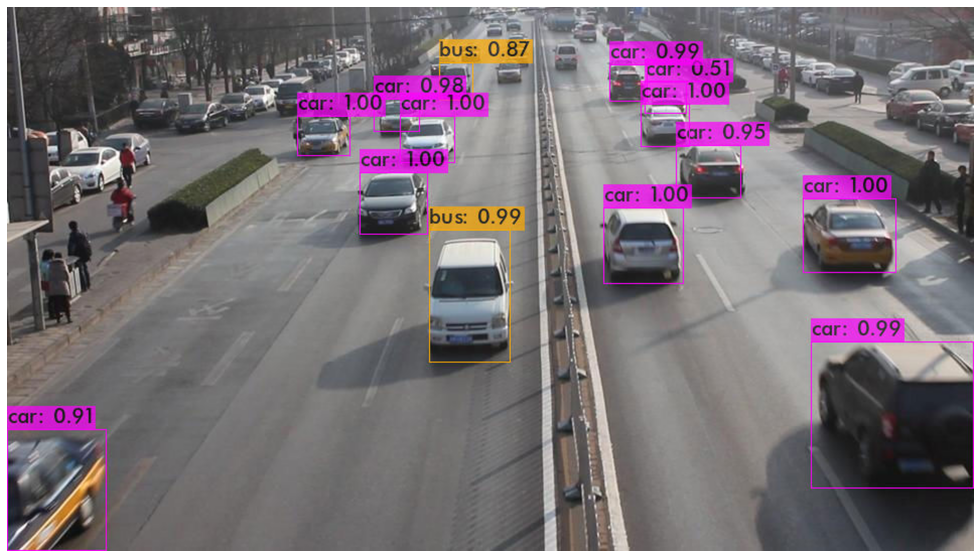

In [ ]:
!./darknet detector test /content/cse6463_22s_120200208/obj.data  /content/cse6463_22s_120200208/yolov3-tiny_obj.cfg  "/content/darknet/backup/yolov3-tiny_obj_best.weights" /content/cse6463_22s_120200208/obj/20035_img00477.jpg -ext_output
imShow('predictions.jpg')

In [ ]:
!cp /content/darknet/backup/yolov3-tiny_obj_best.weights  '/content/drive/My Drive/'